In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor
using Logging

#path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
#path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config.toml"
cfg_file2 = "$(@__DIR__)/../../lDGA_test_runs/config2.toml"

empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file2)
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp_fft2, GLoc_fft2, Σ_loc2, FUpDo2, gImp2, gLoc2 = setup_LDGA(kG, freqList, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2694, χLoc_ch(16:26) = 0.093 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1811947008638526 ?≈? 0.18119470086385256 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities iwth ranges are:
│ χLoc_sp(16:26) = 0.2696, χLoc_ch(16:26) = 0.0932 
└ sum χupup check (normal/improved sum, tail sub sum, expected): 0.1813620894231569 ?≈? 0.1813620894231569 ?≈? 0.25"


In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

bubbleLoc2 = calc_bubble(νGrid2, GImp_fft2, qGridLoc, mP2, sP2);
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp_fft2, FUpDo,
                     qGridLoc, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

# Σ_ladderLoc_ω[20,1,:] 

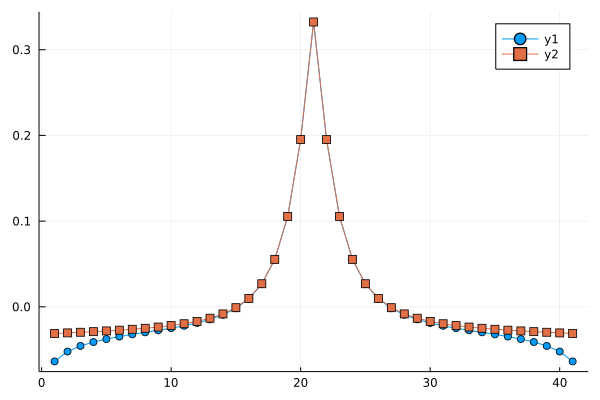

In [4]:
plot(real(locQ_ch.χ),markershape=:circle)
plot!(real(locQ_ch2.χ),markershape=:square)

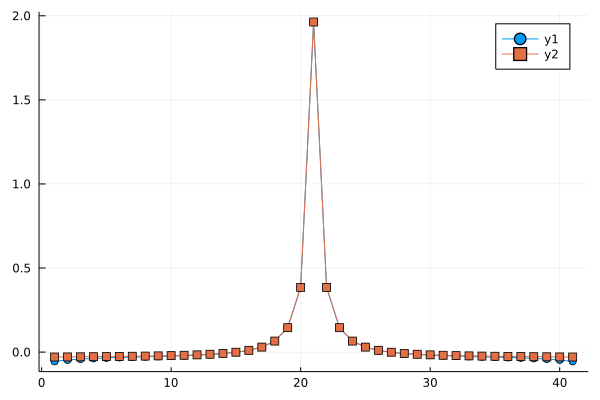

In [5]:
plot(real(locQ_sp.χ),markershape=:circle)
plot!(real(locQ_sp2.χ),markershape=:square)

In [6]:
# non local quantities 
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

In [7]:
# non local quantities 
bubble2 = calc_bubble(νGrid2, GLoc_fft2, qG, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, qG, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, qG, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);

In [8]:
nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)
λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.09156755883093241, rhs = 0.27082184289677275
┌ Info: found 
│   χ_min = -0.0923459536389228
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.0923459536389228, 1.846919072778456]"
┌ Info: Method 2 root:
│   r2 =
│    1-element Vector{Float64}:
└     0.02705260062919633
┌ Info: Found λsp 
└   λsp_old = 0.02705260061584617
[ Info: new lambda correction: λsp=0.3572352708817727 and λch=1.866297370103137e12


(0.02705260061584617, [0.3572352708817727, 1.866297370103137e12], [-0.0923459536389228, 1.846919072778456], [-Inf, Inf])

In [9]:
nlQ_sp2_nλ = deepcopy(nlQ_sp2)
nlQ_ch2_nλ = deepcopy(nlQ_ch2)
λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, qG, mP2, sP2)

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(16:26,16:26) = 16:26 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 16:26, length: 11
│ ch: 16:26, length: 11
│ usable: 16:26, length: 11
└ χch sum = 0.09172594174512728, rhs = 0.40827405825487273
┌ Info: found 
│   χ_min = -0.09234595363898714
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.09234595363898714, 1.8469190727797427]"
┌ Info: Method 2 root:
└   r2 = Float64[]
┌ Info: Found λsp 
└   λsp_old = -0.09113681522706829
[ Info: new lambda correction: λsp=0.42224538739796275 and λch=-24.165010672686815


(-0.09113681522706829, [0.42224538739796275, -24.165010672686815], [-0.09234595363898714, 1.8469190727797427], [-Inf, Inf])

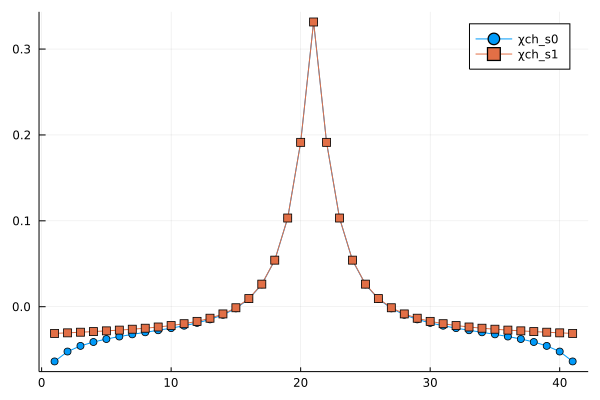

In [10]:
plot(real(LadderDGA.kintegrate(qG, nlQ_ch_nλ.χ, dim=2)[:,1]),markershape=:circle, label="χch_s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_ch2_nλ.χ, dim=2)[:,1]),markershape=:square, label="χch_s1")

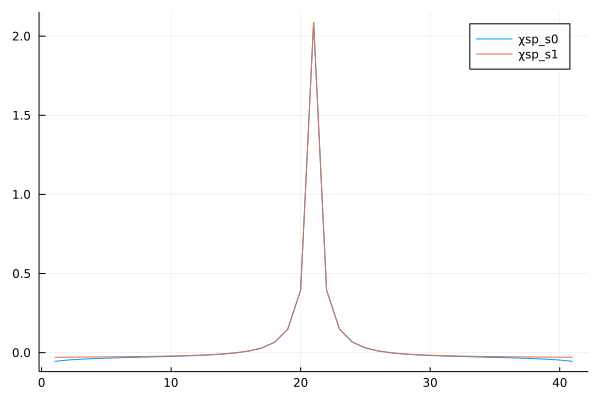

In [11]:
plot(real(LadderDGA.kintegrate(qG, nlQ_sp_nλ.χ, dim=2)[:,1]), label="χsp_s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_sp2_nλ.χ, dim=2)[:,1]), label="χsp_s1")

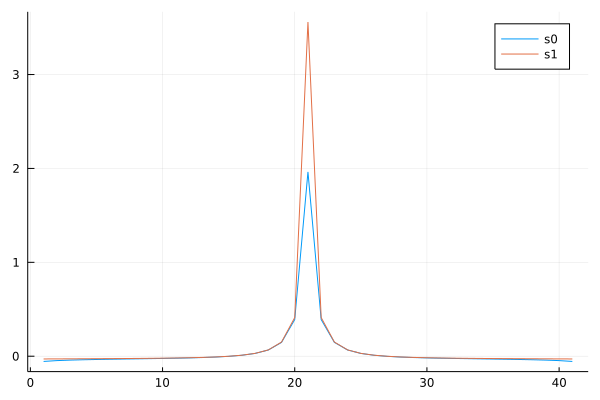

In [12]:
plot(real(LadderDGA.kintegrate(qG, nlQ_sp.χ, dim=2)[:,1]), label="s0")
plot!(real(LadderDGA.kintegrate(qG, nlQ_sp2.χ, dim=2)[:,1]), label="s1")

# Investigation of Tail Fits in Σ(ω)

In [13]:
Σ_ladder = calc_Σ(nlQ_sp_nλ, nlQ_ch_nλ, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]

Σ_ladder2 = calc_Σ(nlQ_sp2_nλ, nlQ_ch2_nλ, bubble2, GLoc_fft2, FUpDo, qG, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc[1:size(Σ_ladder2,1)];

In [14]:
Σ_hartree = mP.n * mP.U/2 
E_pot_tail_c = (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (qG.ϵkGrid .+ Σ_hartree .- mP.μ))
E_pot_tail = E_pot_tail_c' ./ (LadderDGA.iν_array(mP.β, 0:sP.n_iν-1) .^ 2)
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(qG.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c])
t = LadderDGA.G_from_Σ(Σ_ladder_corrected .+ Σ_hartree, qG.ϵkGrid, 0:size(Σ_ladder_corrected, 1)-1, mP)
G_corr = LadderDGA.flatten_2D(t);
LadderDGA.calc_E_pot(qG, G_corr, Σ_ladder_corrected, E_pot_tail, E_pot_tail_inv)

1.6117604338488418

In [15]:
Σ_hartree2 = mP2.n * mP2.U/2 
E_pot_tail_c2 = (mP2.U^2 * 0.5 * mP2.n * (1-0.5*mP2.n) .+ Σ_hartree2 .* (qG.ϵkGrid .+ Σ_hartree2 .- mP2.μ))
E_pot_tail2 = E_pot_tail_c2' ./ (LadderDGA.iν_array(mP2.β, 0:sP2.n_iν-1) .^ 2)
E_pot_tail_inv2 = sum((mP2.β/2)  .* [Σ_hartree2 .* ones(size(qG.ϵkGrid)), (-mP2.β/2) .* E_pot_tail_c2])
t2 = LadderDGA.G_from_Σ(Σ_ladder_corrected2 .+ Σ_hartree2, qG.ϵkGrid, 0:size(Σ_ladder_corrected2, 1)-1, mP2)
G_corr2 = LadderDGA.flatten_2D(t2);
LadderDGA.calc_E_pot(qG, G_corr2, Σ_ladder_corrected2, E_pot_tail2[1:size(Σ_ladder_corrected2, 1),:], E_pot_tail_inv2)

1.5974288061808641

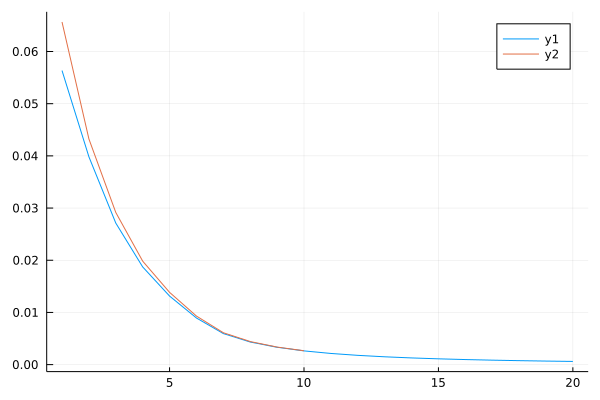

In [20]:
#plot(real(Σ_ladder[:,end]))
#plot!(real(Σ_ladder2[:,end]))
plot(real(Σ_ladder_corrected[:,end]))
plot!(real(Σ_ladder_corrected2[:,end]))

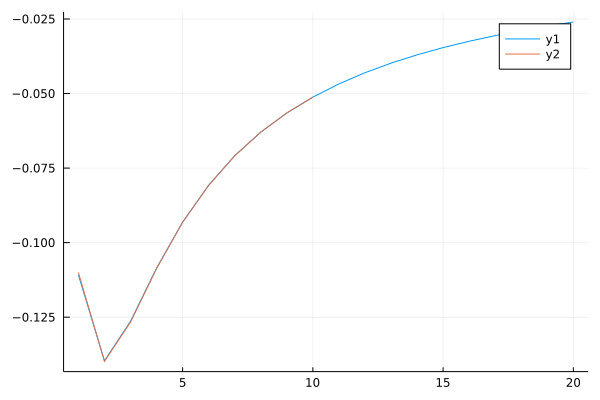

In [21]:
#plot(imag(Σ_ladder[:,end]))
plot(imag(Σ_ladder_corrected[:,end]))
plot!(imag(Σ_ladder_corrected2[:,end]))